In [1]:
%matplotlib inline

## Vis - visualizing transforms
This notebook showcases the `nitransforms.vis` module, which implements the functionality to illustrate and view transforms.

### Preamble
Prepare a Python environment and use a temporal directory for the outputs. After that, fetch the actual file from NiBabel documentation.

In [2]:
import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt
import pytest

import nibabel as nb
from nitransforms.nonlinear import DenseFieldTransform
from nitransforms.vis import PlotDenseField

cwd = TemporaryDirectory()
os.chdir(cwd.name)
print(f"This notebook is being executed under <{os.getcwd()}>.")

This notebook is being executed under </private/var/folders/z0/5s6gsggx5qqfxg5gh56g60jm0000gp/T/tmpbwt0x91d>.


In [3]:
# generalise path here, eg
# transform_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / ".nitransforms"))) / "someones_displacement_field.nii.gz"
anat_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / "Desktop/nitransforms-tests"))) / "someones_anatomy.nii.gz"
transform_file = Path(os.getenv("TEST_DATA_HOME", str(Path.home() / "Desktop/nitransforms-tests"))) / "someones_displacement_field.nii.gz"
print(transform_file)

/Users/julienmarabotto/Desktop/nitransforms-tests/someones_displacement_field.nii.gz


## Load a displacement field
Info about the transform file here...

<OrthoSlicer3D: /Users/julienmarabotto/Desktop/nitransforms-tests/someones_anatomy.nii.gz (57, 67, 56)>

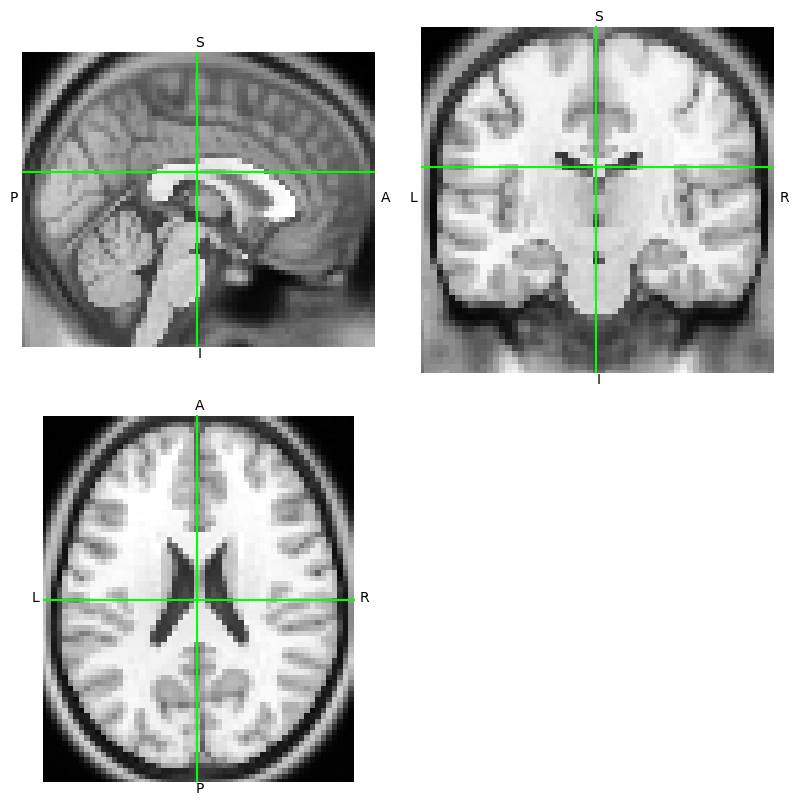

In [4]:
# Load the example
nii = nb.load(anat_file)
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)
nii.orthoview()

## Displacement fields
About displacement fields here...

<OrthoSlicer3D: /Users/julienmarabotto/Desktop/nitransforms-tests/someones_displacement_field.nii.gz (57, 67, 56, 3)>

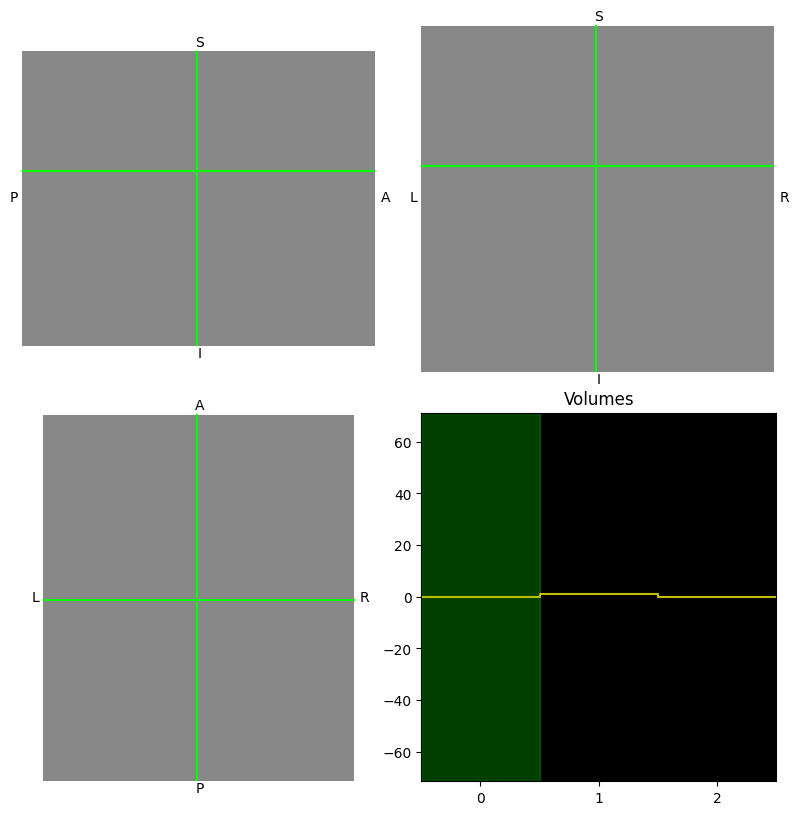

In [5]:
nii = nb.load(transform_file)
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)
nii.orthoview()

... This is now meaningless. We can therefore call PlotDenseField from the 'nitransforms.vis' library to obtain a more meaningful representation.

In [10]:
pdf = PlotDenseField(
    transform=transform_file,
    is_deltas=True,
)
print(pdf._xfm._field.shape)

(57, 67, 56, 3)


/Users/julienmarabotto/workspace/nitransforms/nitransforms/vis.py:221: RuntimeWarning: invalid value encountered in divide
  c = c / c.max()


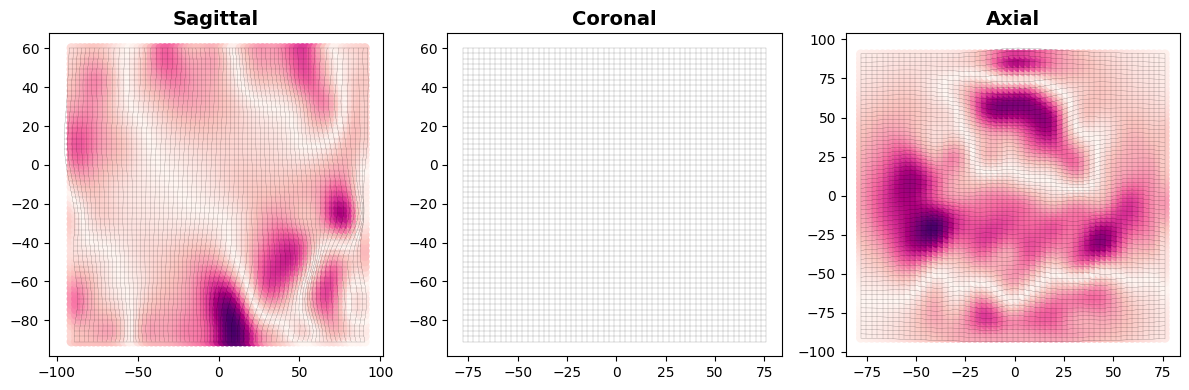

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf.plot_distortion(
    axes=axes,
    xslice=23,
    yslice=35,
    zslice=48,
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


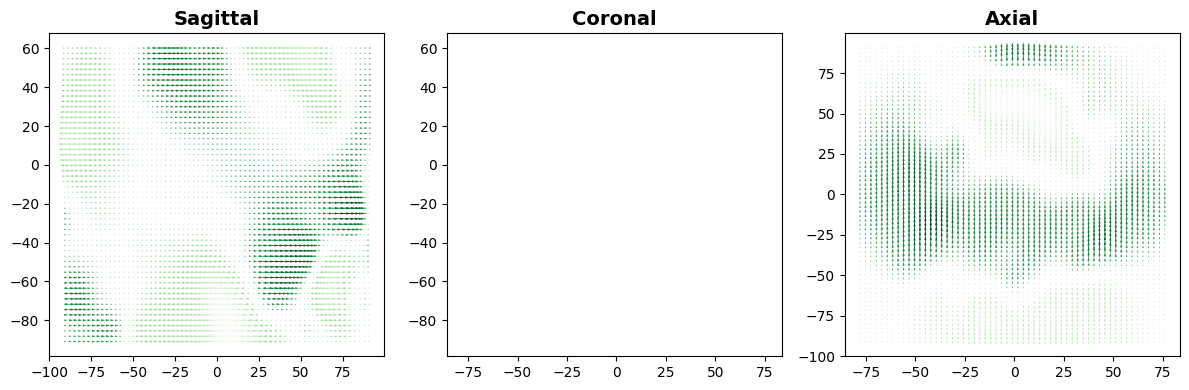

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
pdf.plot_quiverdsm(
    axes=axes,
    xslice=23,
    yslice=35,
    zslice=48,
)